Necesary libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os, time, random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import itertools

Loading the data:

In [ ]:
# Run this just the first time
#!pip install -U wget
#!rm -rf data.zip data lib
#!rm -rf preprocessed
!mkdir -p preprocessed
!mkdir -p checkpoint
!mkdir -p lib

import wget
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/config.yaml', 'lib/config.yaml')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/helper.py', 'lib/helper.py')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/data.zip', 'data.zip')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/preprocessed/data_seq.npz', 'preprocessed/data_seq.npz')
wget.download('https://github.com/shengpu1126/BDSI2019-ML/raw/master/lib/prepare_data.py', 'lib/prepare_data.py')

import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".")

In [2]:
#Run this to load the data if you have downloaded the data before
from lib.helper import load_data
raw_data, df_labels = load_data(120000)

Loading files from disk: 100%|██████████| 12000/12000 [02:29<00:00, 80.06it/s] 


In [3]:
# GPU support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)

using device: cpu


Preparing data:

In [ ]:
%run lib/prepare_data.py

In [4]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()
    def __len__(self):
        return len(self.X)

def get_train_val_test(batch_size=64):
    #f = np.load('preprocessed/data_seq.npz')
    f = np.load('data/data_nmiss_CF.npz')
    f2 = np.load('data/data_miss_CF.npz')
    X, y, y2 = f['X'], f['y'], f2['y']
    X = np.concatenate((X,f2['X']), axis=2)
    X = X.transpose((0,2,1))
    print(X.shape, y.shape)
    
    print('Creating splits')
    Xtr, X__, ytr, y__ = train_test_split(X,   y,   train_size=0.8, stratify=y,   random_state=13)
    Xva, Xte, yva, yte = train_test_split(X__, y__, test_size=0.5, stratify=y__, random_state=13)
    
    tr = SimpleDataset(Xtr, ytr)
    va = SimpleDataset(Xva, yva)
    te = SimpleDataset(Xte, yte)
    
    tr_loader = DataLoader(tr, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(va, batch_size=batch_size)
    te_loader = DataLoader(te, batch_size=batch_size)
    
    print('Feature shape, Label shape, Class balance:')
    print('\t', tr_loader.dataset.X.shape, tr_loader.dataset.y.shape, tr_loader.dataset.y.mean())
    print('\t', va_loader.dataset.X.shape, va_loader.dataset.y.shape, va_loader.dataset.y.mean())
    print('\t', te_loader.dataset.X.shape, te_loader.dataset.y.shape, te_loader.dataset.y.mean())
    return tr_loader, va_loader, te_loader

In [5]:
tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)

(10000, 70, 48) (10000,)
Creating splits


/home/damorgal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Feature shape, Label shape, Class balance:
	 (8000, 70, 48) (8000,) 0.142875
	 (1000, 70, 48) (1000,) 0.143
	 (1000, 70, 48) (1000,) 0.143


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, in_channels, n_filters, output_size, sequence_len):
        super().__init__()
        self.n_filters = n_filters
        self.conv1 = nn.Conv1d(in_channels, n_filters, 3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(n_filters, n_filters, 3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.fc = nn.Linear(int(sequence_len/2/2)*n_filters+1680, output_size)

    def forward(self, x):
        N, d, L = x.shape
        xm = 1 - x[:,35:70,:]
        x = x[:,:35,:]
        #x = torch.Tensor(np.concatenate((x,xd,xt), axis=1))
        #ones = np.array([np.array([np.ones(L) for i in range(d)]) for j in range(N)])
        #xm = torch.Tensor(np.concatenate((xm,ones,ones), axis=1))
        
        # Getting the weights for the trained model
        z = self.conv1(x)
        w = self.conv1.weight
        wm = torch.abs(w) / torch.sum(torch.abs(w), dim=(1,2), keepdim=True)
        
        # Apply the weights to the mask xm
        zm = F.conv1d(xm, wm, padding=1)
        
        # Apply the first set of conv-elu-pool
        z = self.pool1(F.elu(zm*z))
        
        # Apply the second set of conv-elu-pool
        z = self.pool2(F.elu(self.conv2(z)))
        
        # Flatten the output from the convolutional/pooling layers
        z = z.view(N, -1)
        xm = xm.view(N,-1)
        # Add the distance and times of measurements
        z = torch.cat((z,xm),1)
        z = self.fc(z)
        
        # Pass through the output layer and apply sigmoid activation
        z = torch.sigmoid(z)

        return z

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = CNN(35*1, 64, 1, 48)
print('Number of float-valued parameters:', count_parameters(model))

Number of float-valued parameters: 21585


In [8]:
x = torch.zeros((1, 35*2, 48))
model(x)

tensor([[0.4361]], grad_fn=<SigmoidBackward>)

Train the LSTM:

In [9]:
def _train_epoch(data_loader, model, criterion, optimizer):
    """
    Train the `model` for one epoch of data from `data_loader`
    Use `optimizer` to optimize the specified `criterion`
    """
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        # clear parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

def _evaluate_epoch(tr_loader, va_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        # Evaluate on train
        y_true, y_score = [], []
        running_loss = []
        for X, y in tr_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            y_true.append(y.cpu().numpy())
            y_score.append(output.cpu().numpy())
            running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        train_loss = np.mean(running_loss)
        train_score = metrics.roc_auc_score(y_true, y_score)
        print('tr loss', train_loss, 'tr AUROC', train_score)

        # Evaluate on validation
        y_true, y_score = [], []
        running_loss = []
        for X, y in va_loader:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                output = model(X)
                y_true.append(y.cpu().numpy())
                y_score.append(output.cpu().numpy())
                running_loss.append(criterion(output, y).item())

        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
        val_loss = np.mean(running_loss)
        val_score = metrics.roc_auc_score(y_true, y_score)
        print('va loss', val_loss, 'va AUROC', val_score)
    return train_loss, val_loss, train_score, val_score

def save_checkpoint(model, epoch, checkpoint_dir):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
    }

    filename = os.path.join(checkpoint_dir, 'epoch={}.checkpoint.pth.tar'.format(epoch))
    torch.save(state, filename)

(10000, 70, 48) (10000,)
Creating splits


/home/damorgal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Feature shape, Label shape, Class balance:
	 (8000, 70, 48) (8000,) 0.142875
	 (1000, 70, 48) (1000,) 0.143
	 (1000, 70, 48) (1000,) 0.143
Number of float-valued parameters: 21585
Epoch 0
tr loss 0.7011865992546081 tr AUROC 0.47699900134621137
va loss 0.7057576142251492 va AUROC 0.47080807174156064
Epoch 1
tr loss 0.31760324144363405 tr AUROC 0.8273496402128675
va loss 0.3279346590861678 va AUROC 0.821192809524198
Epoch 2
tr loss 0.30838204264640806 tr AUROC 0.8416788611646675
va loss 0.3290533246472478 va AUROC 0.8224086298765412
Epoch 3
tr loss 0.29658098363876345 tr AUROC 0.8534258979622588
va loss 0.32429956272244453 va AUROC 0.8256399376586074
Epoch 4
tr loss 0.2881597434878349 tr AUROC 0.8641289862101058
va loss 0.32911306992173195 va AUROC 0.8265456830217623
Epoch 5
tr loss 0.2848899674415588 tr AUROC 0.8736757183462028
va loss 0.3191095842048526 va AUROC 0.8347218708945664
Epoch 6
tr loss 0.2722750973701477 tr AUROC 0.880073124883015
va loss 0.3226778581738472 va AUROC 0.835080

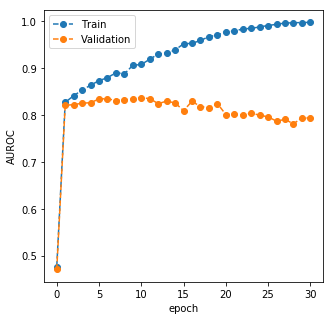

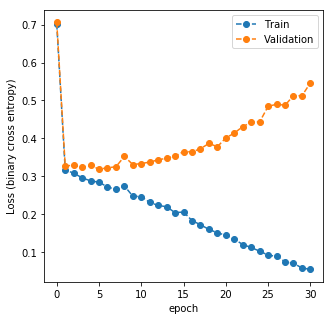

In [10]:
tr_loader, va_loader, te_loader = get_train_val_test(batch_size=64)
    
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

n_epochs = 30
learning_rate = 1e-3

model = CNN(35*1, 64, 1, 48)
print('Number of float-valued parameters:', count_parameters(model))

model = model.to(device)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

outputs = []

print('Epoch', 0)
out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
outputs.append(out)

for epoch in range(0, n_epochs):
    print('Epoch', epoch+1)
    # Train model
    _train_epoch(tr_loader, model, criterion, optimizer)

    # Evaluate model
    out = _evaluate_epoch(tr_loader, va_loader, model, criterion)
    outputs.append(out)

    # Save model parameters
    save_checkpoint(model, epoch+1, 'checkpoint/')

train_losses, val_losses, train_scores, val_scores = zip(*outputs)

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(n_epochs + 1), train_scores, '--o', label='Train')
plt.plot(range(n_epochs + 1), val_scores, '--o', label='Validation')
plt.xlabel('epoch')
plt.ylabel('AUROC')
plt.legend()
plt.savefig('auroc_prop_baseline_new.png', dpi=300)

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(range(n_epochs + 1), train_losses, '--o', label='Train')
plt.plot(range(n_epochs + 1), val_losses, '--o', label='Validation')
plt.xlabel('epoch')
plt.ylabel('Loss (binary cross entropy)')
plt.legend()
plt.savefig('loss_prop_baseline_new.png', dpi=300)


In [20]:
def restore_checkpoint(model, checkpoint_dir, cuda=False):
    """
    If a checkpoint exists, restores the PyTorch model from the checkpoint.
    Returns the model and the current epoch.
    """
    cp_files = [file_ for file_ in os.listdir(checkpoint_dir)
        if file_.startswith('epoch=') and file_.endswith('.checkpoint.pth.tar')]

    if not cp_files:
        print('No saved model parameters found')
        if force:
            raise Exception("Checkpoint not found")
        else:
            return model, 0, []
    
    # Find latest epoch
    for i in itertools.count(1):
        if 'epoch={}.checkpoint.pth.tar'.format(i) in cp_files:
            epoch = i
        else:
            break

    print("Which epoch to load from? Choose in range [1, {}].".format(epoch))
    inp_epoch = int(input())
    if inp_epoch not in range(1, epoch+1):
        raise Exception("Invalid epoch number")

    filename = os.path.join(checkpoint_dir,
        'epoch={}.checkpoint.pth.tar'.format(inp_epoch))

    print("Loading from checkpoint {}".format(filename))
    
    if cuda:
        checkpoint = torch.load(filename)
    else:
        # Load GPU model on CPU
        checkpoint = torch.load(filename,
            map_location=lambda storage, loc: storage)

    try:
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> Successfully restored checkpoint (trained for {} epochs)"
            .format(checkpoint['epoch']))
    except:
        print("=> Checkpoint not successfully restored")
        raise

    return model, inp_epoch

def _evaluate_epoch(data_loader, model, criterion):
    model.eval()
    with torch.no_grad():
        y_true, y_score = [], []
        running_loss = []
        for X, y in data_loader:
            output = model(X)
            y_true.append(y.numpy())
            y_score.append(output)
            running_loss.append(criterion(output, y).item())
        y_true, y_score = np.concatenate(y_true), np.concatenate(y_score)
    
    loss = np.mean(running_loss)
    score = metrics.roc_auc_score(y_true, y_score)
    return loss, score

_, _, te_loader = get_train_val_test(batch_size=64)
model = CNN(35*1, 64, 1, 48)
model, _ = restore_checkpoint(model, 'checkpoint/')
criterion = torch.nn.BCELoss()
loss, score = _evaluate_epoch(te_loader, model, criterion)
print('Test loss :', loss)
print('Test AUROC:', score)

(10000, 70, 48) (10000,)
Creating splits


/home/damorgal/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Feature shape, Label shape, Class balance:
	 (8000, 70, 48) (8000,) 0.142875
	 (1000, 70, 48) (1000,) 0.143
	 (1000, 70, 48) (1000,) 0.143
Which epoch to load from? Choose in range [1, 30].
4
Loading from checkpoint checkpoint/epoch=4.checkpoint.pth.tar
=> Successfully restored checkpoint (trained for 4 epochs)
Test loss : 0.3144259760156274
Test AUROC: 0.8384672503692341
